## Import modules

In [31]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import cross_validation
from glob import glob
from os import path
import csv as csv

## Preparing data

In [2]:
def get_files_in(folder, pattern='*.txt'):
    return glob(path.join(folder, pattern))

def filenames(folder):
    filename = get_files_in(folder, '*.jpg')
    filename1 = get_files_in(folder, '*.mat')
    for i in range(len(filename1)):
        filename.append(filename1[i])
    return filename

In [41]:
def image_lable(file_dir):
    image_dir = filenames(file_dir)
    img_name = []
    for i in range(len(image_dir)):
        image = cv2.imread(image_dir[i]) #read in BGR form
        if image == None: # ignore image that can not be read
            continue
        img_name.append(image_dir[i])
    return np.array(img_name)

In [42]:
df_x = image_lable('Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images')

/Users/mac/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [43]:
df_x

array([ 'Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images/chicken_0001.jpg',
       'Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images/chicken_0002.jpg',
       'Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images/chicken_0003.jpg',
       ...,
       'Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images/dog_0998.jpg',
       'Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images/dog_0999.jpg',
       'Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images/dog_1000.jpg'], 
      dtype='|S74')

In [48]:
df_y = np.repeat(np.array([0,1]),1000)

In [49]:
df_y

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
X_train_name, X_test_name, Y_train, Y_test = cross_validation.train_test_split(df_x, df_y, test_size = 0.2, random_state = 10)

In [51]:
print X_train_name.shape, X_test_name.shape

(1600,) (400,)


## SIFT features

In [7]:
from scipy.cluster.vq import *
from sklearn import preprocessing

In [8]:
df_x[0]

'Fall_2016/GR5243/Project3/Fall2016-proj3-grp3/data/images/chicken_0001.jpg'

In [9]:
image = cv2.imread(df_x[0],0)

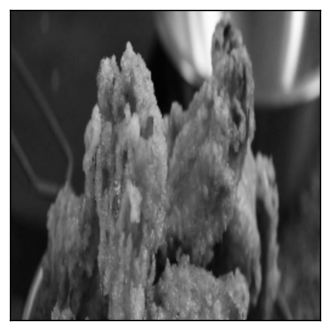

In [10]:
res = cv2.resize(image,(256,256),interpolation = cv2.INTER_LINEAR)
plt.imshow(res, cmap = "gray", interpolation = "bicubic")
plt.xticks([]), plt.yticks([])
plt.show()

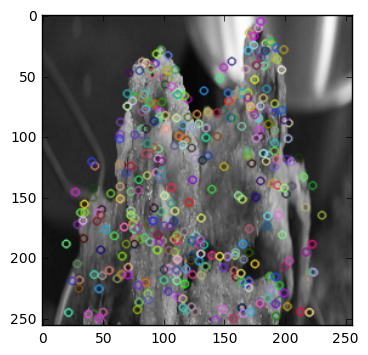

In [11]:
sift=cv2.SIFT()
kp = sift.detect(res,None)

img=cv2.drawKeypoints(res,kp,res)
plt.imshow(img)

In [12]:
def SIFT_feature(img_list):
    sift = cv2.SIFT()
    des_list = []
    for i in range(len(img_list)):
        image = cv2.imread(img_list[i]) #read in BGR form
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # transfer to gray color
        res = cv2.resize(gray,(256,256),interpolation = cv2.INTER_LINEAR) #resize to 256*256
        (kp_sift, descs_sift) = sift.detectAndCompute(res,None)
        des_list.append(descs_sift)
    
    return des_list

In [13]:
def BoW(des_list, word_number, voc):   
    im_features = np.zeros((len(des_list), word_number), "float32")
    for i in range(len(des_list)):
        words, distance = vq(des_list[i],voc)
        for w in words:
            im_features[i][w] += 1
            
    # Perform Tf-Idf vectorization        
    #nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    #idf = np.array(np.log((1.0*len(des_list)+1) / (1.0*nbr_occurences + 1)), 'float32')
    
    # Perform L2 normalization
    #im_features = im_features*idf
    im_features = preprocessing.normalize(im_features, norm='l1')

    return im_features

In [15]:
sift_list_train = SIFT_feature(X_train_name)
sift_list_test = SIFT_feature(X_test_name)

In [16]:
descriptors = sift_list_train[0]
for descriptor in sift_list_train[1:]:
    descriptors = np.vstack([descriptors, descriptor])

In [18]:
descriptors.shape

(733306, 128)

In [23]:
voc_sift, variance = kmeans2(descriptors, 5000, 10)

In [24]:
train_feature = BoW(sift_list_train, 5000, voc_sift)
test_feature = BoW(sift_list_test, 5000, voc_sift)

In [29]:
train_feature.shape

(1600, 5000)

In [32]:
feature_file = open('Fall_2016/GR5243/Project3/Project3_poodleKFC_train/SIFT_features.csv', "wb")
p = csv.writer(feature_file)
for row in train_feature:
    p.writerow(row)

In [34]:
predictions_file.close()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(train_feature[0::,0::],Y_train)
output = forest.predict(test_feature)


## CNN(keras)

In [52]:
import os
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using Theano backend.


In [57]:
weights_path = '/Users/mac/Fall_2016/GR5243/Project3/vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/Users/mac/Fall_2016/GR5243/Project3/Project3_poodleKFC_train/data/train'
validation_data_dir = '/Users/mac/Fall_2016/GR5243/Project3/Project3_poodleKFC_train/data/validation'
nb_train_samples = 1600
nb_validation_samples = 400
nb_epoch = 50

In [54]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    # build the VGG16 network
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # load the weights of the VGG16 networks
    # (trained on ImageNet, won the ILSVRC competition in 2014)
    # note: when there is a complete match between your model definition
    # and your weight savefile, you can simply call model.load_weights(filename)
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print('Model loaded.')
    
    generator = datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

In [55]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy'))
    train_labels = np.array([1] * (nb_train_samples / 2) + [0] * (nb_train_samples / 2))

    validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_labels = np.array([1] * (nb_validation_samples / 2) + [0] * (nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=32,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [58]:
save_bottlebeck_features()
train_top_model()

Model loaded.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 2s - loss: 0.7977 - acc: 0.7519 - val_loss: 0.2266 - val_acc: 0.9250
Epoch 2/50
1600/1600 [==============================] - 1s - loss: 0.3316 - acc: 0.8612 - val_loss: 0.2036 - val_acc: 0.9175
Epoch 3/50
1600/1600 [==============================] - 1s - loss: 0.2125 - acc: 0.9244 - val_loss: 0.3511 - val_acc: 0.8575
Epoch 4/50
1600/1600 [==============================] - 1s - loss: 0.2256 - acc: 0.9156 - val_loss: 0.1894 - val_acc: 0.9300
Epoch 5/50
1600/1600 [==============================] - 1s - loss: 0.1622 - acc: 0.9387 - val_loss: 0.4516 - val_acc: 0.8250
Epoch 6/50
1600/1600 [==============================] - 1s - loss: 0.1427 - acc: 0.9394 - val_loss: 0.2680 - val_acc: 0.9025
Epoch 7/50
1600/1600 [==============================] - 2s - loss: 0.1218 - acc: 0.9519 - val_loss: 0.2278